09:53:03 - cmdstanpy - INFO - compiling stan file /workspace/model2.stan to exe file /workspace/model2
09:53:14 - cmdstanpy - INFO - compiled model executable: /workspace/model2
09:53:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:53:39 - cmdstanpy - INFO - CmdStan done processing.
09:53:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2.stan', line 19, column 2 to column 46)
Consider re-running with show_console=True if the above output is unclear!
09:53:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 26 divergent transitions (2.6%)
	Chain 2 had 21 divergent transitions (2.1%)
	Chain 3 had 55 divergent transitions (5.5%)
	Chain 4 had 297 divergent transitions (29.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


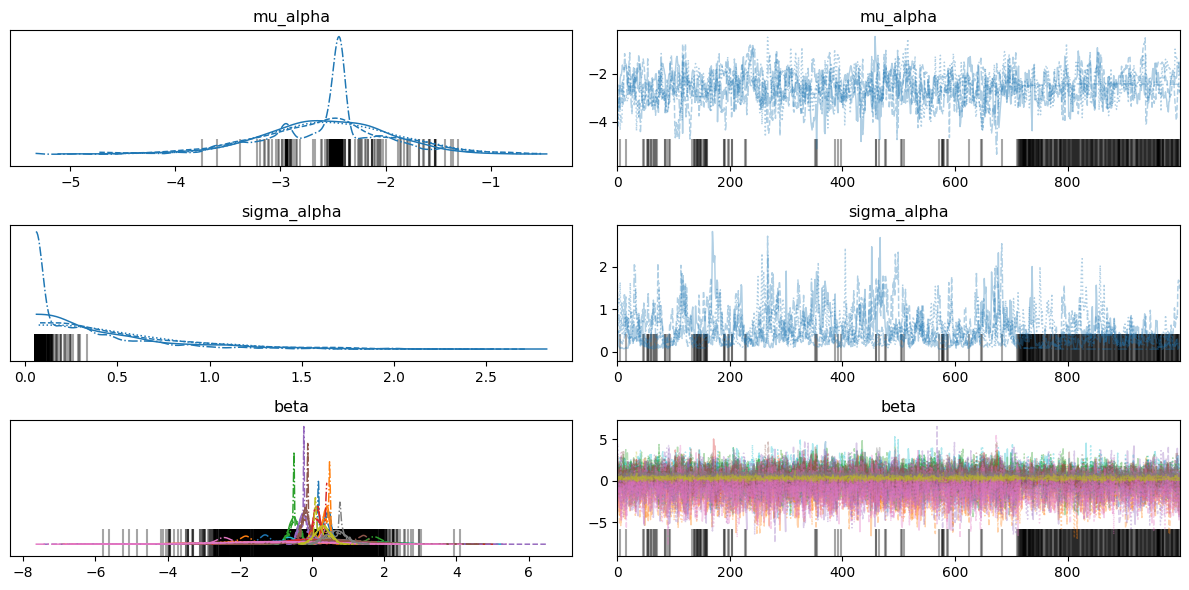

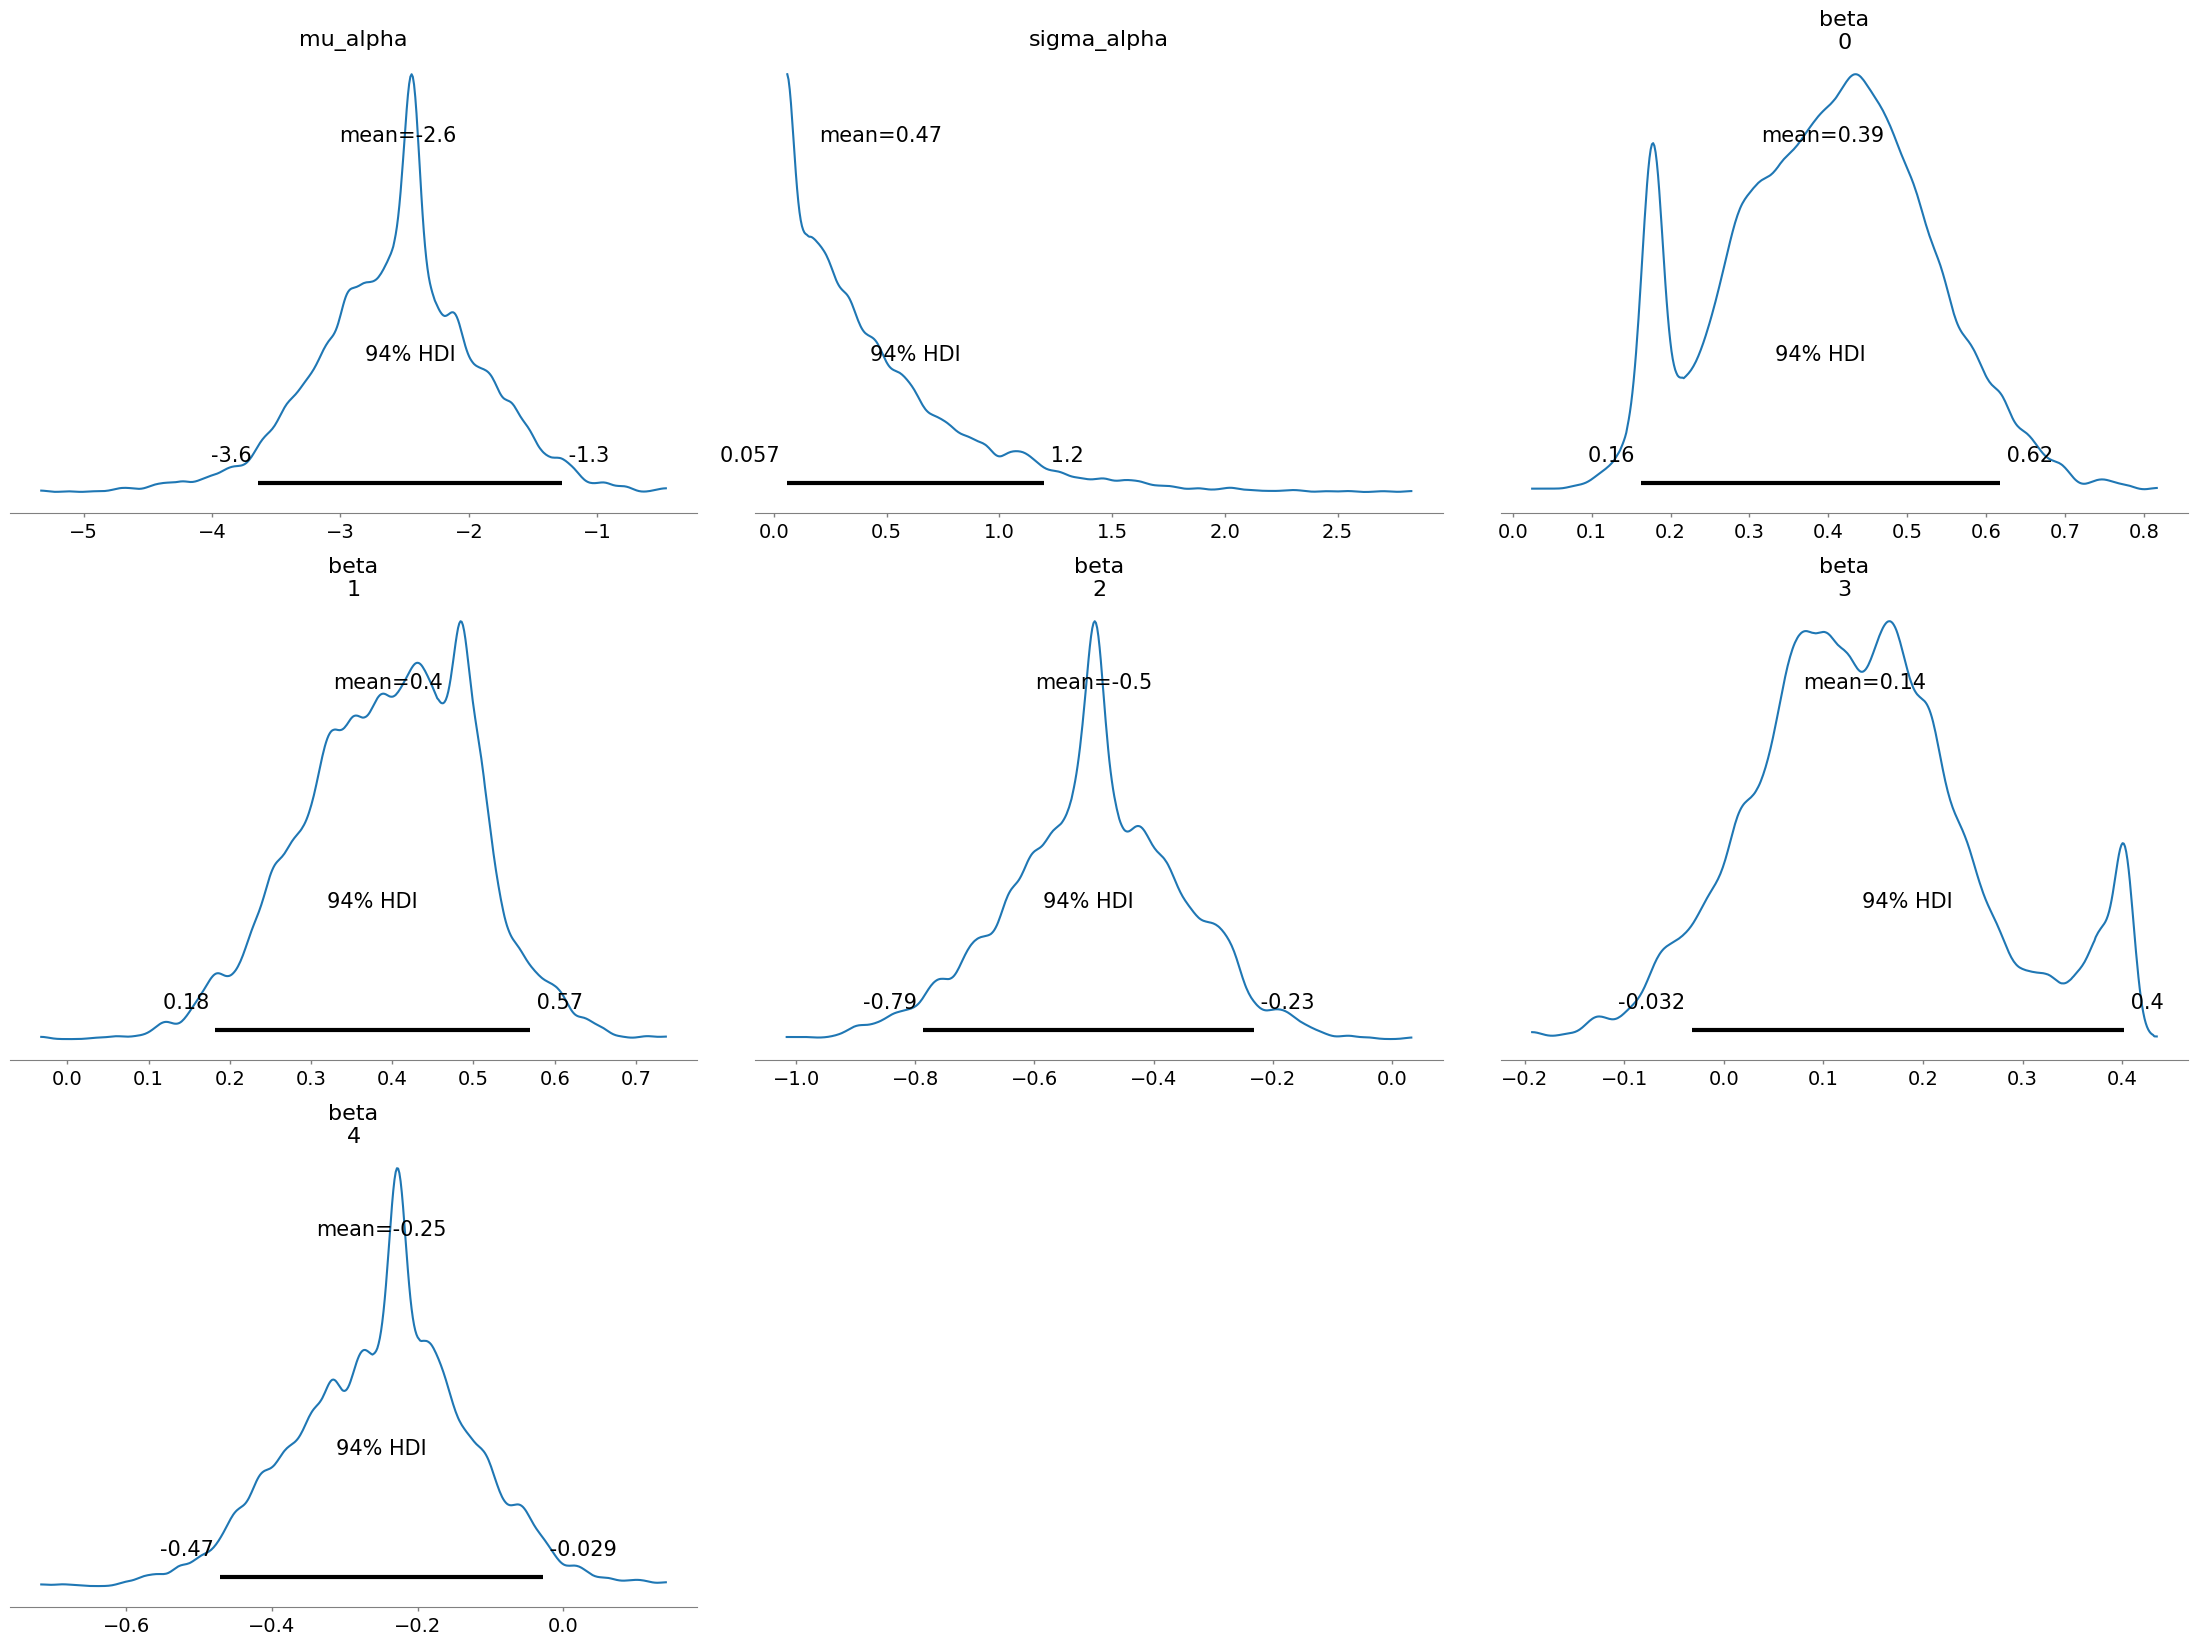

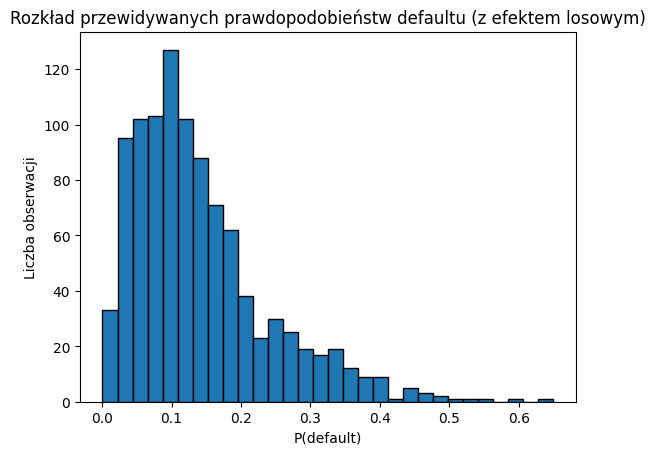

In [3]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from cmdstanpy import CmdStanModel
import arviz as az

# Wczytaj dane
X, y, purpose = joblib.load("processed_data.pkl")

# Przekształcenia
if hasattr(X, 'toarray'):
    X = X.toarray()

X = X.astype(np.float32)
y = y.astype(np.int32)

# Zamień purpose (kategorie) na indeksy 1..G
le = LabelEncoder()
group_id = le.fit_transform(purpose) + 1  # Stan wymaga 1-indeksowania
G = len(le.classes_)
N, K = X.shape

# Dane do Stan
stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist(),
    "G": G,
    "group_id": group_id.tolist()
}

# Wczytaj model2.stan
model = CmdStanModel(stan_file="model2.stan")
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, seed=42)

# Arviz
idata = az.from_cmdstanpy(posterior=fit)

# TRACEPLOT
az.plot_trace(idata, var_names=["mu_alpha", "sigma_alpha", "beta"])
plt.tight_layout()
plt.show()

# POSTERIOR PLOT – beta i efekty grupowe
az.plot_posterior(idata, var_names=["mu_alpha", "sigma_alpha", "beta"], coords={"beta_dim_0": list(range(5))})
plt.tight_layout()
plt.show()

# Średnie z posteriora
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
mu_alpha = posterior_means["mu_alpha"].values.item()
alpha_group = posterior_means["alpha_group"].values.flatten()
beta_mean = posterior_means["beta"].values

# Predykcja: logity z efektem grupowym
logits = np.array([alpha_group[g - 1] + X[i] @ beta_mean for i, g in enumerate(group_id)])
probs = 1 / (1 + np.exp(-logits))

# Histogram
plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład przewidywanych prawdopodobieństw defaultu (z efektem losowym)")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()
